# Funciones Auxiliares

In [ ]:
library(MASS)
library(rpart)
library(class)

#Ejercicio 1

In [ ]:
centroGauss <- function(d, v) {
  return(rep(v, d))
}

covMatrix <- function(d, C) {
  return(diag((C * sqrt(d))^2, d, d))
}


diagonales <- function(n, d, C) {
  n0 <- floor(n / 2)
  n1 <- n - n0
  matriz <- covMatrix(d, C)

  # Generar datos multivariados
  valores0 <- MASS::mvrnorm(n0, centroGauss(d, -1), matriz)
  valores1 <- MASS::mvrnorm(n1, centroGauss(d, 1), matriz)

  # Construir los datos con etiquetas de clase
  data <- rbind(cbind(Target = 0, valores0), cbind(Target = 1, valores1))

  # Convertir a data frame y asignar nombres a las columnas
  colnames(data) <- c('Target', paste0('d', 1:d))

  return(as.data.frame(data))
}

In [ ]:
cartesian_to_polar <- function(x, y) {
  rho <- sqrt(x^2 + y^2)
  theta <- atan2(y, x)
  return(list(rho = rho, theta = theta))
}

# Comprobar si un punto está dentro de una curva
is_inside_curve <- function(rho, theta, npi) {
  rho_curve1 <- (theta + (npi - 1) * pi) / (4 * pi)
  rho_curve2 <- (theta + npi * pi) / (4 * pi)
  return(rho_curve1 <= rho && rho <= rho_curve2)
}

# Comprobar si un punto está dentro de las espirales definidas
is_inside_curves <- function(x, y) {
  polar <- cartesian_to_polar(x, y)
  rho <- polar$rho
  theta <- polar$theta
  return(is_inside_curve(rho, theta, 1) || is_inside_curve(rho, theta, 3) || is_inside_curve(rho, theta, 5))
}

# Generar puntos espirales
espirales <- function(n) {
  n0 <- floor(n / 2)
  n1 <- n - n0
  i0 <- 0
  i1 <- 0
  values0 <- list()
  values1 <- list()

  while (i0 + i1 < n) {
    # Generar coordenadas aleatorias uniformemente distribuidas entre -1 y 1
    coords <- runif(2, min = -1, max = 1)
    x <- coords[1]
    y <- coords[2]

    # Comprobar si el punto está dentro de un círculo de radio 1
    if (sqrt(x^2 + y^2) > 1) next

    # Clasificar el punto según si está dentro de las espirales
    if (is_inside_curves(x, y)) {
      if (i0 < n0) {
        values0[[i0 + 1]] <- c(0, x, y)
        i0 <- i0 + 1
      }
    } else {
      if (i1 < n1) {
        values1[[i1 + 1]] <- c(1, x, y)
        i1 <- i1 + 1
      }
    }
  }

  # Combinar los puntos de ambas clases
  data <- do.call(rbind, c(values0, values1))
  colnames(data) <- c("Target", "d1", "d2")

  return(as.data.frame(data))
}

# Ejercicio 2

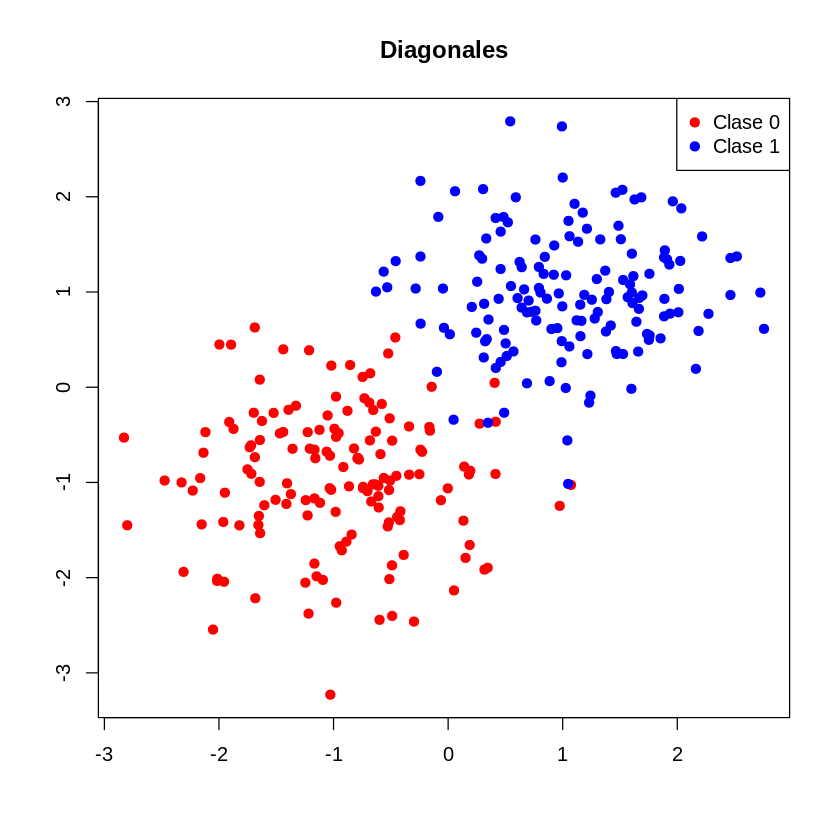

In [ ]:
df <- diagonales(300, 2, 0.5)

plot(df[,-1], col = ifelse(df$Target == 0, "red", "blue"),
     pch = 19, xlab = "", ylab = "", main = "Diagonales")
legend("topright", legend = c("Clase 0", "Clase 1"), col = c("red", "blue"), pch = 19)

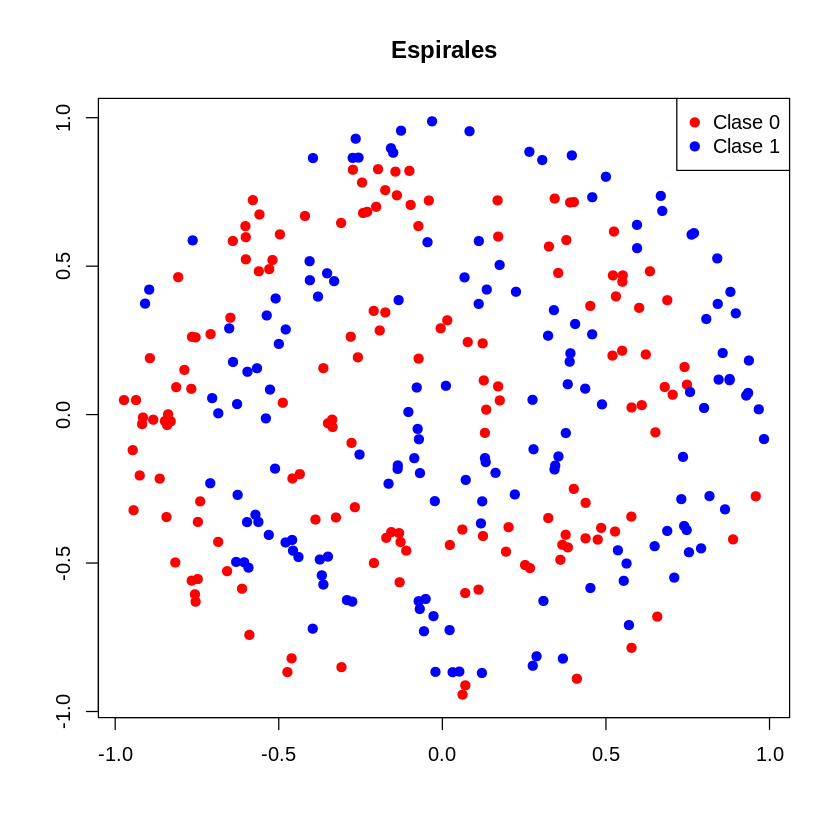

In [ ]:
df <- espirales(300)

plot(df[-1], col = ifelse(df$Target == 0, "red", "blue"),
     pch = 19, xlab = "", ylab = "", main = "Espirales")
legend("topright", legend = c("Clase 0", "Clase 1"), col = c("red", "blue"), pch = 19)

# Ejercicio 3

In [ ]:
diagonales_train <- diagonales(300, 2, 0.7)
diagonales_test <- diagonales(10000, 2, 0.7)

espirales_train <- espirales(300)
espirales_test <- espirales(10000)

## Sin K-fold

### Tree

In [ ]:
arbol <- rpart(Target ~ ., data = diagonales_train, method = "class")

test_predict <- predict(arbol, diagonales_test[,-1], type = "class")

tree_error <- mean(test_predict != diagonales_test$Target)

cat("Error diagonales:", tree_error, "\n")

Error diagonales: 0.0927 


In [ ]:
arbol <- rpart(Target ~ ., data = espirales_train, method = "class")

test_predict <- predict(arbol, espirales_test[,-1], type = "class")

tree_error <- mean(test_predict != espirales_test$Target)

cat("Error espirales:", tree_error, "\n")

Error espirales: 0.2163 


### KNN

In [ ]:
k <- 3
predicciones <- knn(train = diagonales_train[,-1], test = diagonales_test[,-1], cl = diagonales_train[,1], k = k)

knn_error <- mean(predicciones != diagonales_test[,1])
cat("Error diagonales:", knn_error)

Error diagonales: 0.0884

In [ ]:
k <- 3
predicciones <- knn(train = espirales_train[,-1], test = espirales_test[,-1], cl = espirales_train[,1], k = k)

knn_error <- mean(predicciones != espirales_test[,1])
cat("Error espirales:", knn_error)

Error espirales: 0.1406

## 5-fold cross-validation

In [ ]:
folds <- 5

diagonales_folds <- split(diagonales_train, cut(seq_len(nrow(diagonales_train)), folds, labels = FALSE))

espirales_folds <- split(espirales_train, cut(seq_len(nrow(espirales_train)), folds, labels = FALSE))

### Tree

In [ ]:
error <- 0

for (n in 1:folds) {
  diagonales_train <- do.call(rbind, diagonales_folds[-n])

  diagonales_test <- do.call(rbind, diagonales_folds[n])

  arbol <- rpart(Target ~ ., data = diagonales_train, method = "class")

  test_predict <- predict(arbol, diagonales_test[,-1], type = "class")

  error <- error + mean(test_predict != diagonales_test$Target)
}

cat("Error promedio diagonales:", error/folds, "\n")

Error promedio diagonales: 0.1166667 


In [ ]:
error <- 0

for (n in 1:folds) {
  espirales_train <- do.call(rbind, espirales_folds[-n])

  espirales_test <- do.call(rbind, espirales_folds[n])

  arbol <- rpart(Target ~ ., data = espirales_train, method = "class")

  test_predict <- predict(arbol, espirales_test[,-1], type = "class")

  error <- error + mean(test_predict != espirales_test$Target)
}

cat("Error promedio espirales:", error/folds, "\n")

Error promedio espirales: 0.34 


### KNN

In [ ]:
error <- 0

for (n in 1:folds) {
  diagonales_train <- do.call(rbind, diagonales_folds[-n])

  diagonales_test <- do.call(rbind, diagonales_folds[n])

  k <- 3
  predicciones <- knn(train = diagonales_train[,-1], test = diagonales_test[,-1], cl = diagonales_train[,1], k = k)

  error <- error + mean(predicciones != diagonales_test[,1])
}

cat("Error promedio diagonales:", error/folds, "\n")

Error promedio diagonales: 0.1366667 


In [ ]:
error <- 0

for (n in 1:folds) {
  espirales_train <- do.call(rbind, espirales_folds[-n])

  espirales_test <- do.call(rbind, espirales_folds[n])

  k <- 3
  predicciones <- knn(train = espirales_train[,-1], test = espirales_test[,-1], cl = espirales_train[,1], k = k)

  error <- error + mean(predicciones != espirales_test[,1])
}

cat("Error promedio espirales:", error/folds, "\n")

Error promedio espirales: 0.24 


## Comentarios
Como se esperaba, entrenando con los 300 puntos genero un mejor entrenamiento que haciendo el foldeo, de cualquier manera, impresiona el hecho de que no haya aumentado tanto el error en ninguno de los casos. Esto se debe a que, aunque nunca se entrene con las 300 muestras en cada iteracion, a lo largo de todas las vueltas se hayan podido tener en cuenta todos los puntos para poder alcanzar un mejor promedio de error.

Hablando mas especificamente sobre diferencias entre predicciones en cada dataset, era esperable que en su mayoria se consiguiera un mejor error en diagonales que en espirales. Esto se debe a que en espirales hay mas zonas donde se presentan muestras de diferentes clases lo cual afecta a ambos metodos (arboles y KNN).

KNN tiende a tener un mejor rendimiento que arboles debido a que la simplicidad de su algoritmo es la que le permite alcanzar un mejor error. En el caso de arboles, para alcanzar un menor error, este tendria que generar muchas mas divisiones para poder dividir adecuadamente las clases en ambos datasets. Mientras que KNN solo le basta con tomas las n muestras mas cercanas y determinar la clase mas probable.